In [1]:
from os import listdir
from os.path import join
import pickle
import pandas as pd
import numpy as np
from scipy.stats import zscore
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
from statsmodels.stats.multitest import multipletests
from scipy.stats import ks_2samp
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from lmfit import Model
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sgt.sgt import SGT
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
import logomaker
import seaborn as sns
from tqdm.notebook import tqdm

c:\Users\mikeo\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\mikeo\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\mikeo\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
Matplotlib is building the font cache; this may take a moment.


In [2]:
plt.rc('font', size=9)          # controls default text sizes
plt.rc('axes', titlesize=9)     # fontsize of the axes title
plt.rc('axes', labelsize=9)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=8)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)    # fontsize of the tick labels
plt.rc('legend', fontsize=9)    # legend fontsize
plt.rc('figure', titlesize=9)  # fontsize of the figure title

In [3]:
df = pd.read_csv('./output/netMHCpan/NetMHCpan-output_labeled.csv', index_col=[0], dtype=str)
df.HLA_type = [x.split('-')[1][0] + '*' + x.split('-')[1][1:] for x in df.HLA_type]
df['Count'] = [1]*len(df)
tested = df[(df.IEDB.isna() == False)]
untested = df[df.IEDB.isna()]

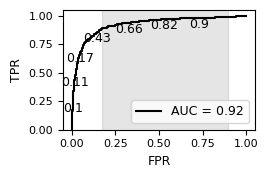

In [4]:
fig, ax = plt.subplots(figsize=(2.65, 1.85))
y = []
for i in tested.IEDB:
    if i == 'False':
        y.append(0)
    else:
        y.append(1)
el_scores = tested['EL-score']
ba_scores = tested['BA-score']

X = np.array([el_scores.values, ba_scores.values]).T
logit = LogisticRegression(random_state=0).fit(X, y)
y_pred = logit.predict_proba(X)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y, y_pred, pos_label=1)
ax.plot(fpr, tpr, label='AUC = ' + str(round(metrics.auc(fpr, tpr), 2)), c='k')

count = 0
points = [(0, 0), (1, 1)]
for i, j, k in zip(fpr, tpr, thresholds[::-1]):
    mindist = 1
    for p in points:
        d = np.sqrt(np.abs(i - p[0])**2 + np.abs(j - p[1])**2)
        if d < mindist:
            mindist = d
    if mindist > 0.2:
        ax.text(i, j, round(k, 2), verticalalignment='top', c='k', horizontalalignment='center')
        points.append((i, j))
x0 = np.absolute(thresholds[::-1] - 0.5).argmin()
x1 = np.absolute(thresholds[::-1] - 0.95).argmin()
ax.fill_between([fpr[x0], fpr[x1]], -1, 2, color='grey', alpha=0.2)
ax.set_ylim([-0.0, 1.05])
ax.set_xlim([-0.05, 1.05])
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.legend()
plt.tight_layout()
plt.savefig('images/Figure1E.svg')
plt.show()
plt.close()

C:\Users\mikeo\AppData\Local\Temp\ipykernel_8236\601298707.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tested.loc[:, 'Validated'] = tested.IEDB != 'False'
C:\Users\mikeo\AppData\Local\Temp\ipykernel_8236\601298707.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


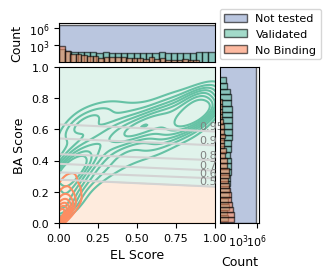

In [5]:
def linear(x, m, b):
    return m * x + b

df['Probability'] = logit.predict_proba(df[['EL-score', 'BA-score']].values)[:, 1]
tested = df[(df.IEDB.isna() == False)]
untested = df[df.IEDB.isna()]
tested.loc[:, 'Validated'] = tested.IEDB != 'False'
pos = tested.loc[tested.Validated == True].copy()
neg = tested.loc[tested.Validated == False].copy()
pos.loc[:, 'EL-score'] = pd.to_numeric(pos['EL-score'])
neg.loc[:, 'EL-score'] = pd.to_numeric(neg['EL-score'])
pos.loc[:, 'BA-score'] = pd.to_numeric(pos['BA-score'])
neg.loc[:, 'BA-score'] = pd.to_numeric(neg['BA-score'])

points_x = [x/10. for x in range(-50,+50)]
line_bias = logit.intercept_
line_w = logit.coef_.T
points_y = [(line_w[0][0]*x+line_bias[0])/(-1*line_w[1][0]) for x in points_x]

colors1 = plt.get_cmap('Set2').colors
colors2 = plt.get_cmap('Pastel2').colors

fig = plt.figure(figsize=(2.5, 2.5))

gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4), 
                      left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0])
ax_histy = fig.add_subplot(gs[1, 1])

ax.fill_between(points_x, points_y, [1]*len(points_y), color=colors2[0], alpha=0.4)
ax.fill_between(points_x, points_y, [0]*len(points_y), color=colors2[1], alpha=0.4)
sns.kdeplot(data=pos, x="EL-score", y="BA-score", fill=False, bw_adjust=1, color=colors1[0],
            levels=8, thresh=.2, alpha=1., ax=ax)
sns.kdeplot(data=neg, x="EL-score", y="BA-score", fill=False, bw_adjust=1, color=colors1[1],
            levels=8, thresh=.2, alpha=1., ax=ax)

for cutoff in np.append(np.arange(0.5, 1., 0.1), np.array([0.95])):
    tmp = tested.loc[(tested.Probability < cutoff + .01) & (tested.Probability > cutoff - .01)]
    x, y = pd.to_numeric(tmp['EL-score']), pd.to_numeric(tmp['BA-score'])
    popt, pcov = curve_fit(linear, x, y)
    xfit = np.arange(0, 2, .1)
    ax.plot(xfit, linear(xfit, *popt), c='lightgrey')
    ax.text(0.9, linear(1, *popt)+.015, str(round(cutoff, 2)), c='grey', fontsize=8)
    
ax.set_ylim([0, 1])
ax.set_xlim([0, 1])
ax.set_xlabel('EL Score')
ax.set_ylabel('BA Score')

bins = 25
ax_histx.hist(untested['EL-score'], color=colors1[2], alpha=0.6, bins=bins, edgecolor='k')
ax_histx.hist(pos['EL-score'], color=colors1[0], alpha=0.6, bins=bins, edgecolor='k')
ax_histx.hist(neg['EL-score'], color=colors1[1], alpha=0.6, bins=bins, edgecolor='k')
ax_histx.set_xlim([0, 1])
ax_histx.set_yscale('log')
ax_histx.set_ylabel('Count')
ax_histx.set_xticks([])
ax_histx.set_yticks([1e3, 1e6])

ax_histy.hist(untested['BA-score'], color=colors1[2], alpha=0.6, bins=bins, edgecolor='k', orientation='horizontal', label='Not tested')
ax_histy.hist(pos['BA-score'], color=colors1[0], alpha=0.6, bins=bins, edgecolor='k', orientation='horizontal', label='Validated')
ax_histy.hist(neg['BA-score'], color=colors1[1], alpha=0.6, bins=bins, edgecolor='k', orientation='horizontal', label='No Binding')
ax_histy.set_ylim([0, 1])
ax_histy.set_xscale('log')
ax_histy.set_xlabel('BA Score')
ax_histy.set_xlabel('Count')
ax_histy.set_yticks([])
ax_histy.set_xticks([1e3, 1e6])

plt.legend(loc=[0, 1.05], fontsize=8)
plt.tight_layout()
plt.savefig('images/Figure1D.svg')
plt.show()
plt.close()

In [6]:
if 'pdict.pkl' in listdir('./output'):
    with open('./output/pdict.pkl', 'rb') as f:
        pdict = pickle.load(f)
else:
    pdict = {}
    prange = np.arange(0.5, 0.95, 0.01)
    for tq, i in zip(tqdm(prange), prange):
        untested_copy = untested.copy()
        untested_copy.HLA_type = [x.split('*')[0] for x in untested_copy.HLA_type]
        tmp = untested_copy[(untested_copy.Probability >= i)].groupby(['HLA_type', 'Protein']).sum()
        for x in tmp.index:
            if x in pdict:
                pdict[x].append(tmp.loc[x].Count)
            else:
                pdict[x] = [tmp.loc[x].Count]
    with open('./output/pdict.pkl', 'wb') as f:
        pickle.dump(pdict, f)

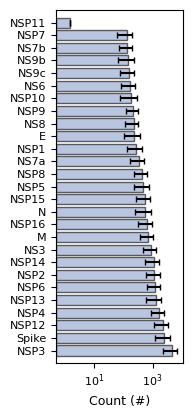

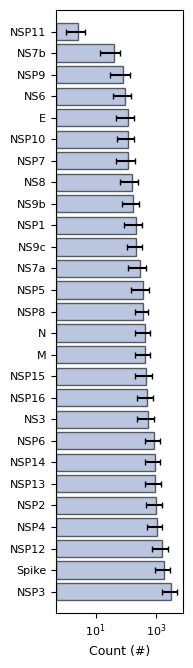

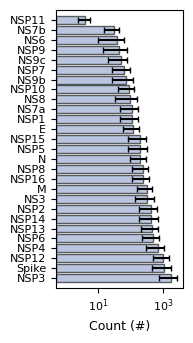

In [7]:
tsum = tested[(tested.Validated == True)].groupby('HLA_type').sum().sort_values('HLA_type')
ax_sizes = [(2, 4.25), (2, 6.75), (2, 3.5)]
for ix, gene in enumerate(['A', 'B', 'C']):
    alleles, umean, ustd, t = [], [], [], []
    for allele in list(pdict):
        if gene in allele:
            alleles.append(allele)
            umean.append(np.mean(pdict[allele]))
            ustd.append(np.std(pdict[allele]))
            if allele in tsum.index:
                t.append(tsum.loc[allele].Count)
            else:
                t.append(0)
    o = pd.DataFrame({'Allele' : [x[1] for x in alleles], 'Validated' : t, 'Mean' : umean, 'Std' : ustd}).sort_values('Mean', ascending=False)
    fig, ax = plt.subplots(figsize=ax_sizes[ix])
    ax.barh(o.Allele, o.Validated, left=0.5, color=colors1[0], edgecolor='k', alpha=0.6, height=0.8, label='Validated')
    ax.barh(o.Allele, o.Mean, left=0.5+o.Validated, color=colors1[2], xerr=o.Std, capsize=2, height=0.8,
        edgecolor='k', alpha=0.6, label='Not tested')
    #plt.xticks(rotation=90)
    plt.ylim([-1, len(o)])
    plt.xlabel('Count (#)')
    plt.xscale('log')
    #plt.legend()
    plt.tight_layout()
    plt.savefig('images/Figure1' + gene + '.svg')
    plt.show()
    plt.close()

In [8]:
class nestedDict(dict):
    def __missing__(self, key):
        value = self[key] = type(self)()
        return value

def filter_interactions(baf, elf, path, model):
    ba = pd.read_pickle(join(path, baf))
    if len(ba) > 0:
        el = pd.read_pickle(join(path, elf))
        protein = baf.split('_')[0]
        ba_filtered = ba[ba >= 0.1].dropna(how='all').T.dropna(how='all')
        el_filtered = el[el >= 0.1].dropna(how='all').T.dropna(how='all')
        if len(ba_filtered) > 0 and len(el_filtered) > 0:
            ba_filtered = ba_filtered.T.stack().dropna(how='all').stack().dropna(how='all').stack().dropna(how='all').stack().dropna()
            el_filtered = el_filtered.T.stack().dropna(how='all').stack().dropna(how='all').stack().dropna(how='all').stack().dropna()
            out = pd.DataFrame(ba_filtered, columns=['BA']).merge(pd.DataFrame(el_filtered, columns=['EL']), left_index=True, right_index=True).dropna().droplevel(4).reset_index()[['residues', 'peptide', 'mutation', 'allele', 'BA', 'EL']].drop_duplicates()
            out.columns = ['residues', 'Peptide Sequence', 'Mutation', 'Allele', 'BA', 'EL']
            start = [x[0]+1 for x in out.residues]
            stop = [x[1]+1 for x in out.residues]
            out['Residue Start'] = start
            out['Residue Stop'] = stop
            out['Protein'] = [protein]*len(out)
            out['Probability'] = model.predict_proba(out[['EL', 'BA']].values)[:, 1]
            out = out[out.Probability >= 0.5]
        else:
            out = pd.DataFrame()
    else:
        out = pd.DataFrame()
    return out

data = pd.read_csv(join('input', 'data.csv'))

with open('./input/UM_mutation_dict.pkl', 'rb') as file:
    muts = pickle.load(file)

if 'MASTER.pkl' in listdir('./output/netMHCpan/pkl'):
    MASTER = pd.read_pickle('./output/netMHCpan/pkl/MASTER.pkl')
else:
    MASTER = pd.DataFrame()
    ba_files = [x for x in listdir('./output/netMHCpan/pkl') if 'BA.pkl' in x]
    el_files = [x.replace('BA', 'EL') for x in ba_files]
    for tq, baf, elf in zip(tqdm(range(len(ba_files))), ba_files, el_files):
        out = filter_interactions(baf, elf, './output/netMHCpan/pkl', logit)
        if len(out) > 0 and MASTER.empty:
            MASTER = out[['Allele', 'Protein', 'Mutation', 'Residue Start', 'Residue Stop', 'Peptide Sequence', 'EL', 'BA', 'Probability']]
        elif len(out) > 0:
            MASTER = pd.concat([MASTER, out[['Allele', 'Protein', 'Mutation', 'Residue Start', 'Residue Stop', 'Peptide Sequence', 'EL', 'BA', 'Probability']]])
    MASTER.to_pickle('./output/netMHCpan/pkl/MASTER.pkl')

for c in data.columns:
    if '-' in c:
        new = []
        for v in data[c]:
            if isinstance(v, str):
                new.append(':'.join(v.strip(' ').split(' ')[0].split(':')[:2]).split('(')[0].strip('Q'))
            else:
                new.append('')
        data[c] = new


if 'sample_dict.pkl' in listdir('./output'):
    with open('./output/sample_dict.pkl', 'rb') as file:
        sample_dict = pickle.load(file)
else:
    sample_dict = {}
    for tq, row1 in zip(tqdm(range(len(data))), data.iterrows()):
        sample_df = pd.DataFrame()
        sid = row1[1].SAMPLE_ID
        gisaid = row1[1].gisaid_epi_isl
        alleles = [row1[1]['A-1'], row1[1]['A-2'], row1[1]['B-1'], row1[1]['B-2'], row1[1]['C-1'], row1[1]['C-2']]
        for p in muts[gisaid]:
            m = muts[gisaid][p]
            for a in alleles:
                tmp = MASTER[(MASTER.Allele == a) & (MASTER.Protein == p) & (MASTER.Mutation.isin(['WT'] + m))]
                duplicated = tmp[tmp['Peptide Sequence'].duplicated()]['Peptide Sequence'].unique()
                for d in duplicated:
                    if len(tmp[tmp['Peptide Sequence'] == d].Mutation.unique()) > 1:
                        tmp = tmp.drop(tmp[((tmp['Peptide Sequence'] == d) & (tmp.Mutation == 'WT'))].index.values)
                sample_df = pd.concat([sample_df, tmp])
        sample_dict[sid] = sample_df

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [9]:
if 'R1z.csv' not in listdir('./output'):
    columns = ['ID', 'Probability', 'SOFA', 'A', 'B', 'C', 'Sex', 'Age', 'BMI']
    Rz, R1z, R2z = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    R1 = pd.DataFrame()
    for tq, i in zip(tqdm(range(len(np.arange(0.5, 1., 0.01)))), np.arange(0.5, 1., 0.01)):
        reg_data = []
        for row in data.iterrows():
            out = [row[1].SAMPLE_ID, i, row[1][-1]]
            for gene in ['A\*', 'B\*', 'C\*']:
                tmp = sample_dict[row[1][0]]
                out.append(len(tmp[(tmp.Allele.str.contains(gene)) & (tmp.Probability >= i)]))
            if 'Female' in row[1].SEX:
                out.append(1)
            else:
                out.append(0)
            out.append(row[1].AGE)
            out.append(row[1].BMI)
            reg_data.append(out)

        regdf1 = pd.DataFrame(data=reg_data, columns=columns)
        if regdf1.sum(axis=0)[1:].min() > 0:
            R1 = pd.concat([R1, regdf1])
            for c in regdf1.columns[3:]:
                regdf1[c] = zscore(regdf1[c])
            R1z = pd.concat([R1z, regdf1])

    R1z.to_csv('output/R1z.csv', index=False)
else:
    R1z = pd.read_csv('output/R1z.csv')

```r
library(brms)
library(ggplot2)
library(extrafont)
library(bayesplot)
library(svglite)
                             
setwd('C:/Users/mikeo/Documents/jnb/SARS_HLA/peptide_binding_predictions/')
                             
color_scheme_set("gray")                                
                                      
r1z <- read.csv('output/R1z.csv')
dat <- r1z[r1z$Probability >= 0.5 & r1z$Probability <= 0.95,]
grouped <- aggregate(. ~ ID, dat, function(x) c(mean = mean(x), sd = sd(x)))
df <- data.frame(
    y = grouped$SOFA[,1], Am = grouped$A[,1], As = grouped $A[,2], Bm = grouped $B[,1], Bs = grouped$B[,2],
    Cm = grouped$C[,1], Cs = grouped$C[,2], Sex = grouped$Sex[,1], Age = grouped$Age[,1], BMI = grouped$BMI[,1]
    )
fit <- brm(y ~ me(Am, As) + me(Bm, Bs) + me(Cm, Cs) + Sex + Age + BMI, data = df,
           save_pars = save_pars(latent = TRUE), control=list(max_treedepth=100), iter=10000)

ce <- conditional_effects(fit, 'Cm')
write.csv(ce$Cm, './output/conditional_effects_C.csv')
write.csv(ce$Bm, './output/conditional_effects_A.csv')
write.csv(ce$Am, './output/conditional_effects_A.csv')
write.csv(ce$Bm, './output/conditional_effects_B.csv')
write.csv(ce$Age, './output/conditional_effects_age.csv')
write.csv(ce$Sex, './output/conditional_effects_sex.csv')
write.csv(ce$BMI, './output/conditional_effects_bmi.csv')

svglite('images/Figure1F.svg', width=2.5, height=3)
plot <- mcmc_plot(fit, type="intervals", variable=c("bsp_meAmAs", "bsp_meBmBs", "bsp_meCmCs", "b_BMI", "b_Age", "b_Sex"), prob=0.5, prob_outer=0.95)
plot(plot + labs(x="Standardized Coefficient") + theme(axis.text.x=element_text(size=9), axis.text.y=element_text(size=10), axis.title = element_text(size=10)) + scale_y_discrete(limits=rev, labels=c("bsp_meCmCs" = "HLA-C", "bsp_meBmBs" = "HLA-B", "bsp_meAmAs" = "HLA-A", "b_BMI" = "BMI", "b_Age" = "Age", "b_Sex" = "Sex")) + theme(text=element_text(family='Arial', face='plain', size=8)))            
dev.off()

In [11]:
if 'correlation_dict.pkl' in listdir('./output'):
    with open('./output/correlation_dict.pkl', 'rb') as file:
        correlation_dict = pickle.load(file)    
else:
    correlation_dict = nestedDict()
    for tq, row in zip(tqdm(range(len(data))), data.iterrows()):
        sample = row[1].SAMPLE_ID
        sofa = row[1].HIGHEST_SOFA_10DAY
        correlation_dict[sample]['SOFA'] = sofa
        data = sample_dict[sample]
        for gene in ['A', 'B', 'C']:
            for protein in data.Protein.unique():
                for cutoff in np.arange(0.5, 0.95, 0.01):
                    n = len(data[(data.Allele.str.contains(gene)) & (data.Protein == protein) & (data.Probability >= cutoff)])
                    correlation_dict[sample][gene][protein][cutoff] = n
    with open('./output/correlation_dict.pkl', 'wb') as file:
        pickle.dump(correlation_dict, file)
                    
C = []
samples = list(correlation_dict)
proteins = ['NSP1', 'NSP2', 'NSP3', 'NSP4', 'NSP5', 'NSP6', 'NSP7', 'NSP8', 'NSP9', 'NSP10', 'NSP11', 'NSP12', 'NSP13', 'NSP14', 'NSP15', 'NSP16', 'Spike',
              'NS3', 'E', 'M', 'NS6', 'NS7a', 'NS7b', 'NS8', 'NS9b', 'NS9c', 'N']
for gene in ['A', 'B', 'C']:
    g = []
    for cutoff in np.arange(0.5, 0.96, 0.01):
        c = []
        for protein in proteins:
            tmp = [correlation_dict[s][gene][protein][cutoff] for s in list(samples)]
            x = []
            for t in tmp:
                if isinstance(t, int) == False:
                    x.append(0)
                else:
                    x.append(t)
            y = [correlation_dict[s]['SOFA'] for s in list(samples)]
            c.append(pearsonr(x, y)[0])
        g.append(c)
    C.append(g)

c:\Users\mikeo\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


C:\Users\mikeo\AppData\Local\Temp\ipykernel_8236\391255857.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tested['Gene'] = [x.split('\*')[0] for x in tested.HLA_type]
C:\Users\mikeo\AppData\Local\Temp\ipykernel_8236\391255857.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tested['Gene'] = [x.split('\*')[0] for x in tested.HLA_type]
C:\Users\mikeo\AppData\Local\Temp\ipykernel_8236\391255857.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

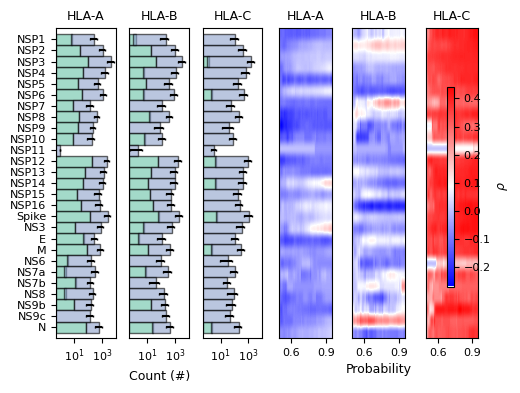

In [12]:
order_dict = {'NSP1' : 0, 'NSP2': 1, 'NSP3' : 2, 'NSP4' : 3, 'NSP5' : 4, 'NSP6' : 5, 'NSP7' : 6, 'NSP8' : 7, 'NSP9' : 8,
              'NSP10' : 9, 'NSP11' : 10, 'NSP12' : 11, 'NSP13' : 12, 'NSP14' : 13, 'NSP15' : 14, 'NSP16' : 15, 'Spike' : 16,
              'NS3' : 17, 'E' : 18, 'M' : 19, 'NS6' : 20, 'NS7a' : 21, 'NS7b' : 22, 'NS8' : 23, 'NS9b' : 24, 'NS9c' : 25, 'N' : 26}

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(5, 4))
for gene, ax in zip(['A', 'B', 'C'], [ax1, ax2, ax3]):
    tested['Gene'] = [x.split('\*')[0] for x in tested.HLA_type]
    #tsum = tested[(tested.Validated == True) & (tested.HLA_type.str.contains(gene))].drop_duplicates(['Peptide', 'Protein', 'Gene']).groupby('Protein').sum().sort_values('Protein')
    tsum = tested[(tested.Validated == True) & (tested.HLA_type.str.contains(gene))][['Protein', 'Count']].groupby('Protein').sum().sort_values('Protein', ascending=False)
    proteins, umean, ustd, t = [], [], [], []
    gene_dict = {}
    for entry in list(pdict):
        if gene in entry[0]:
            if entry[1] in gene_dict:
                gene_dict[entry[1]] = gene_dict[entry[1]] + pdict[entry]
            else:
                gene_dict[entry[1]] = pdict[entry]
    for prot in gene_dict:
        proteins.append(prot)
        umean.append(np.mean(gene_dict[prot]))
        ustd.append(np.std(gene_dict[prot]))
        if prot in tsum.index:
            t.append(tsum.loc[prot].Count)
        else:
            t.append(0)
    o = pd.DataFrame({'Protein' : proteins, 'Validated' : t, 'Mean' : umean, 'Std' : ustd}).sort_values(by=['Protein'], key=lambda x: x.map(order_dict), ascending=False)
    ax.barh(o.Protein, o.Validated, height=1, color=colors1[0], left=0.5, edgecolor='k', alpha=0.6)
    ax.barh(o.Protein, o.Mean, left=o.Validated, color=colors1[2], xerr=o.Std, capsize=1,
           height=1, edgecolor='k', alpha=0.6)
    ax.set_xscale('log')
    ax.set_xlim([5e-1, 1e4])
    ax.set_xticks([1e1, 1e3])
    ax.set_ylim([-1, 27])
    ax.set_title('HLA-' + gene)
ax2.set_yticks([])
ax3.set_yticks([])
#ax1.set_xlabel('HLA-A (#)')
ax2.set_xlabel('Count (#)')
#ax3.set_xlabel('HLA-C (#)')
plt.xticks(rotation=0)

genes = ['A', 'B', 'C']
C = np.nan_to_num(np.array(C))
for i, ax in enumerate([ax4, ax5, ax6]):
    im = ax.imshow(C[i, ::-1, :].T, cmap='bwr', aspect=10, vmin=np.min(C), vmax=np.max(C))
    ax.set_title('HLA-' + genes[i])
    ax.set_xticks([10, 40])
    ax.set_xticklabels([0.6, 0.9])
    ax.set_yticks([])

ax5.set_xlabel('Probability')
cbar_ax = fig.add_axes([0.9, 0.275, 0.015, 0.5])
fig.colorbar(im, cax=cbar_ax, label=r'$\rho$')
#cbar_ax.set_title(r'$\rho$')
plt.tight_layout()
plt.savefig('images/Figure2AB.svg')
plt.show()
plt.close()

In [13]:
if 'overlap_dict.pkl' in listdir('./output'):
    with open('./output/overlap_dict.pkl', 'rb') as file:
        overlap_dict = pickle.load(file)
else:
    overlap_dict = nestedDict()
    for tq, s in zip(tqdm(range(len(sample_dict))), list(sample_dict)):
        d = sample_dict[s]
        for p in np.arange(0.5, 0.96, 0.01):
            al = list(d[(d.Allele.str.contains('A')) & (d.Probability >= p)]['Peptide Sequence'])
            bl = list(d[(d.Allele.str.contains('B')) & (d.Probability >= p)]['Peptide Sequence'])
            cl = list(d[(d.Allele.str.contains('C')) & (d.Probability >= p)]['Peptide Sequence'])
            oa, ob, oab = 0, 0, 0
            for ci in cl:
                if ci in al and ci in bl:
                    oab += 1
                elif ci in al:
                    oa += 1
                elif ci in bl:
                    ob += 1
            overlap_dict[s][round(p, 2)]['AB'] = oab
            overlap_dict[s][round(p, 2)]['A'] = oa
            overlap_dict[s][round(p, 2)]['B'] = ob
            overlap_dict[s][round(p, 2)]['AB_total'] = len(al) + len(bl)
            overlap_dict[s][round(p, 2)]['A_total'] = len(al)
            overlap_dict[s][round(p, 2)]['B_total'] = len(bl)
    with open('./output/overlap_dict.pkl', 'wb') as file:
        pickle.dump(overlap_dict, file)

data = pd.read_csv(join('input', 'data.csv'))
samples = list(overlap_dict)
sofa = [data[data.SAMPLE_ID == s].HIGHEST_SOFA_10DAY.values[0] for s in samples]

if 'peptide_table.pkl' in listdir('./output'):
    peptide_table = pd.read_pickle('./output/peptide_table.pkl')
else:
    pcor_dict = nestedDict()
    peptides = df[(df.Probability >= 0.5) & (df.HLA_type.str.contains('C'))].Peptide.unique()
    for tq, peptide in zip(tqdm(range(len(peptides))), peptides):
        name = ''
        for p in np.arange(0.5, 0.96, 0.01):
            xval = []
            for s in samples:
                tmp = sample_dict[s]
                tmp = tmp[(tmp['Peptide Sequence'] == peptide) & (tmp['Probability'] >= p)]
                xval.append(len(tmp))
                if len(tmp) > 0:
                    name = tmp.Protein.values[0] + ' ' + tmp.Mutation.values[0] + ' ' + str(tmp['Residue Start'].values[0]) + ' ' + str(tmp['Residue Stop'].values[0]) + ' ' + tmp['Peptide Sequence'].values[0]
            pcor_dict[name][round(p, 2)] = pearsonr(xval, sofa)[0]
    pcor_df = pd.DataFrame(pcor_dict).replace(np.nan, 0.).T
    pcor_df['Mean'] = pcor_df.mean(axis=1)
    pcor_df['Std'] = pcor_df.std(axis=1)
    pcor_df = pcor_df.sort_values('Mean', ascending=False)
    pcor_df['MS'] = pcor_df.Mean - pcor_df.Std


    sigCorr = pcor_df.copy()
    protein = [x.split(' ')[0] for x in sigCorr.index if x != '']
    mutation = [x.split(' ')[1] for x in sigCorr.index if x != '']
    residues = [x.split(' ')[2] + ' - ' + x.split(' ')[3] for x in sigCorr.index if x != '']
    sequence = [x.split(' ')[4] for x in sigCorr.index if x != '']
    mean = sigCorr[sigCorr.index != ''].Mean.values
    std = sigCorr[sigCorr.index != ''].Std.values
    n = [len(x) for x in sequence]
    peptide_table = pd.DataFrame(data={'Protein' : protein, 'Mutation' : mutation, 'Residues' : residues, 
                                    'Sequence' : sequence, 'Length' : n, 'Mean' : mean, 'Std' : std})
    peptide_table.to_pickle('./output/peptide_table.pkl')

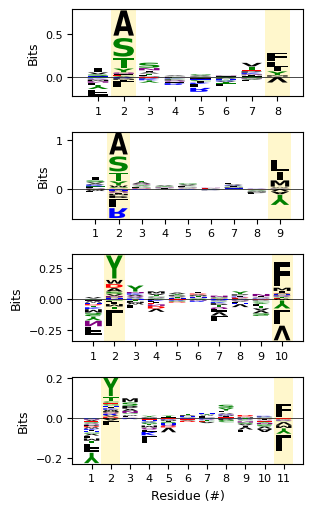

In [14]:
upper = peptide_table.sort_values('Mean', ascending=False).iloc[:round(len(peptide_table)/20)].Mean.min()
lower = peptide_table.sort_values('Mean', ascending=True).iloc[:round(len(peptide_table)/20)].Mean.max()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(3.2, 5.2))
p2 = 7
for i, ax in zip([8, 9, 10, 11], [ax1, ax2, ax3, ax4]):
    peptide_tableA = peptide_table[(peptide_table.Length == i) & (peptide_table.Mean > upper)]
    peptide_tableB = peptide_table[(peptide_table.Length == i) & (peptide_table.Mean < lower)]
    pepA = list(peptide_tableA.Sequence.values)
    pepB = list(peptide_tableB.Sequence.values)
    ww_dfA = logomaker.alignment_to_matrix(pepA, to_type='information')
    ww_dfB = logomaker.alignment_to_matrix(pepB, to_type='information')
    ww_df = ww_dfA - ww_dfB
    ww_df = ww_df.replace(np.nan, 0.)
    ww_logo = logomaker.Logo(ww_df,
                             #font_name='Stencil Std',
                             color_scheme='chemistry',
                             vpad=.1,
                             width=.8,
                             edgecolor='k',
                             ax=ax)
#                             figsize=(4.5, 1.5))
    ww_logo.style_xticks(anchor=0, spacing=1, rotation=0)
    ww_logo.highlight_position(p=1, color='gold', alpha=.2)
    ww_logo.highlight_position(p=p2, color='gold', alpha=.2)
    p2+=1
    ww_logo.ax.set_ylabel('Bits')
    ww_logo.ax.set_xlim([-1, len(ww_df)])
    ww_logo.ax.set_xticklabels([x+1 for x in range(i)])
    if ax == ax4:
        ww_logo.ax.set_xlabel('Residue (#)')
    #ax.set_ylim([0, 1.4])
plt.tight_layout()
plt.savefig(join('images', 'Figure2CDEF.svg'))
plt.show()
plt.close()

In [15]:
if 'mutant_dict.pkl' in listdir('./output'):
    with open('./output/mutant_dict.pkl', 'rb') as file:
        mutant_dict = pickle.load(file)
else:
    mutant_dict = nestedDict()
    files = [f for f in listdir('output/netMHCpan/pkl')] 
    for tq, f in zip(tqdm(range(len(files))), files):
        if '_BA.pkl' in f:
            pkl = pd.read_pickle(join('output/netMHCpan/pkl', f)).reset_index()
            if len(pkl) > 0:
                pkl = pkl[pkl.residues.isin(list(pkl[pkl.mutation != 'WT'].residues))]
                for r in pkl.residues.unique():
                    tmp = pkl[pkl.residues == r]
                    protein = f.split('_')[0]
                    wt_peptide = tmp[tmp.mutation == 'WT'].peptide
                    mut_peptide = tmp[tmp.mutation != 'WT'].peptide
                    mutant_dict[wt_peptide.values[0]]['Protein'] = protein
                    mutant_dict[wt_peptide.values[0]]['Sequence'] = mut_peptide.values[0]
                    mutant_dict[wt_peptide.values[0]]['Residues'] = r
                    mutant_dict[wt_peptide.values[0]]['Mutation'] = tmp[tmp.mutation != 'WT'].mutation.values[0]
    with open('./output/mutant_dict.pkl', 'wb') as file:
        pickle.dump(mutant_dict, file)

if 'plot_df.pkl' in listdir('./output'):
    plot_df = pd.read_pickle('./output/plot_df.pkl')
else:
    prob, mut, peptide, mutant = [], [], [], []
    for tq, s in zip(tqdm(range(len(peptide_table))), peptide_table.Sequence):
        if s in mutant_dict:
            m = mutant_dict[s]['Sequence']
            prot = mutant_dict[s]['Protein']
            mr = mutant_dict[s]['Mutation']
            mp = df[(df.Peptide == m) & (df.HLA_type.str.contains('C'))].Probability.values
            wp = df[(df.Peptide == s) & (df.HLA_type.str.contains('C'))].Probability.values
            combined = ''
            for k, l in zip(s, m):
                if k == l:
                    combined+=k
                else:
                    combined+='['+k+'/'+l+']'
            for w in wp:
                prob.append(w)
                mut.append('WT')
                peptide.append(s)
                mutant.append(prot + ' ' + mr + '\n' + combined)
            for m in mp:
                prob.append(m)
                mut.append('MUT')
                peptide.append(s)
                mutant.append(prot + ' ' + mr + '\n' + combined)

    plot_df = pd.DataFrame(data={'Probability' : prob, 'Strain' : mut, 'Peptide' : mutant})
    plot_df.to_pickle('./output/plot_df.pkl')

In [16]:
pvalues = []
for tq, p in zip(tqdm(range(len(plot_df))), plot_df.Peptide): #.unique():
    WT = plot_df[(plot_df.Peptide == p) & (plot_df.Strain == 'WT')].Probability.values
    MUT = plot_df[(plot_df.Peptide == p) & (plot_df.Strain == 'MUT')].Probability.values
    stat, pval = ks_2samp(WT, MUT)
    pvalues.append(pval)
    #if pval <= 0.05:
    #    print(p, pval)
plot_df['p'] = pvalues

length = []
for pept in plot_df.Peptide:
    length.append(len(pept.split('\n')[1].replace('[', '').replace('/', '').replace(']', '')) - 1)
plot_df['N'] = length

p_corr = multipletests(plot_df[['Peptide', 'p']].drop_duplicates().p.values, method='fdr_twostage')[1]
replace_dict = {}
for ix, row in enumerate(plot_df[['Peptide', 'p']].drop_duplicates().iterrows()):
    replace_dict[row[1].Peptide] = p_corr[ix]

replace_p = []
for tq, row in zip(tqdm(range(len(plot_df))), plot_df.iterrows()):
    replace_p.append(replace_dict[row[1].Peptide])

plot_df['pc'] = replace_p

  0%|          | 0/8360 [00:00<?, ?it/s]

  0%|          | 0/8360 [00:00<?, ?it/s]

C:\Users\mikeo\AppData\Local\Temp\ipykernel_8236\1588712935.py:31: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=plot_df2, y='Probability', x='Peptide', hue='Strain', split=True, inner=None, palette='Set2', ax=ax, scale='width')


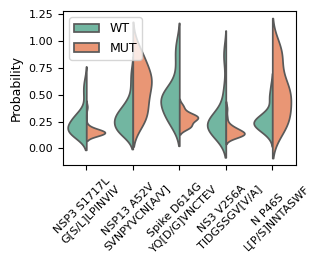

In [17]:
order_dict = {'NSP1 E41K\nVLS[E/K]ARQHL' : 0,
    'NSP1 D75E\nYVFIKRS[D/E]A' : 1,
    'NSP2 S65F\nYTER[S/F]EKSYEL' : 2,
    'NSP3 S702F\n[S/F]TQLGIEFL' : 3,
    'NSP3 S702F\nQ[S/F]TQLGIEF' : 4,
    'NSP3 S702F\nYSGQ[S/F]TQL' : 5,
    'NSP3 S1717L\nG[S/L]LPINVIV' : 6, 
    'NSP3 S1717L\nG[S/L]LPINVIVF' : 7,
    'NSP4 T327I\nLFLMSF[T/I]VL' : 8,
    'NSP6 L37F\n[L/F]YENAFLPF' : 9, 
    'NSP6 L37F\nFF[L/F]YENAF' : 10,
    'NSP6 L37F\nFF[L/F]YENAFL' : 11,
    'NSP13 A52V\nSVNPYVCN[A/V]' : 12,
    'Spike D614G\nYQ[D/G]VNCTEV' : 13,
    'Spike A684V\nR[A/V]RSVASQSI' : 14,
    'NS3 Q57H\n[Q/H]SASKIITL' : 15, 
    'NS3 V256A\nTIDGSSGV[V/A]' : 16,
    'NS3 V256A\nHTIDGSSGV[V/A]' : 17, 
    'NS7a Q94K\nV[Q/K]ELYSPIF' : 18,
    'NS7b S31L\nIFWF[S/L]LEL' : 19, 
    'NS9b T72I\nAFQL[T/I]PIAV' : 20,
    'NS9b T72I\nL[T/I]PIAVQM' : 21,
    'NS9c V27F\nAA[V/F]KPLLV' : 22,
    'N P46S\nL[P/S]NNTASWF' : 23,
    'N R68G\nFP[R/G]GQGVPI' : 24 }

plot_df2 = plot_df[(plot_df.pc <= 0.05)]
plot_df2 = plot_df2.sort_values('Strain', ascending=False).sort_values(by=['Peptide', 'Strain'], key=lambda x: x.map(order_dict), ascending=True)
#plot_df2.Peptide = [x.split('\n')[0] for x in plot_df2.Peptide]
fig, ax = plt.subplots(figsize=(3., 2))
sns.violinplot(data=plot_df2, y='Probability', x='Peptide', hue='Strain', split=True, inner=None, palette='Set2', ax=ax, scale='width')
#ax.scatter([1], [1.1], marker='*', c='k')
plt.xlabel('')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.savefig('images/Figure2G.svg')
plt.show()
plt.close()

In [18]:
def calc_overlap(x, c):
    dup = pd.Series(np.append(x, c)).duplicated()
    return len(dup[dup == True]) / len(x) * 100

probabilities = np.arange(0.5, 0.96, 0.01)
if 'overlap_df.pkl' in listdir('./output') and 'venn_dict.pkl' in listdir('./output'):
    overlap_df = pd.read_pickle('./output/overlap_df.pkl')
    with open('./output/venn_dict.pkl', 'rb') as file:
        venn_dict = pickle.load(file)
else:
    aoverlap, boverlap = [], []
    venn_dict = {}
    for tq, p in zip(tqdm(range(len(probabilities))), probabilities):
        A = df[(df.HLA_type.str.contains('A')) & (df.Probability >= p)].sort_values('Peptide').Peptide.unique()
        B = df[(df.HLA_type.str.contains('B')) & (df.Probability >= p)].sort_values('Peptide').Peptide.unique()
        C = df[(df.HLA_type.str.contains('C')) & (df.Probability >= p)].sort_values('Peptide').Peptide.unique()
        aoverlap.append(calc_overlap(A, C))
        boverlap.append(calc_overlap(B, C))
        venn_dict[round(p, 2)] = [set(A), set(B), set(C)]
        
    with open('./output/venn_dict.pkl', 'wb') as file:
        pickle.dump(venn_dict, file)
        
    overlap_df = pd.DataFrame(data = {'Probability' : probabilities, 'A' : aoverlap, 'B' : boverlap})
    overlap_df.to_pickle('./output/overlap_df.pkl')

0.3330651569204525 0.3698084298549249
0.003636010269696901 0.00931299464214239
-0.033248999099039916 0.07636674445932701
0.5619559845419594 0.9351130691786348


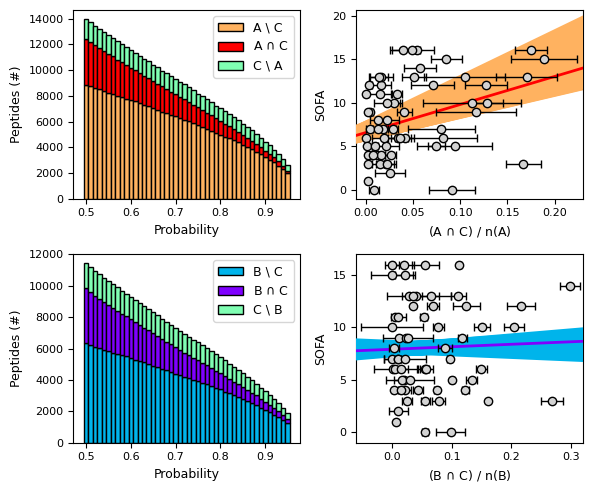

In [19]:
def linear(x, m, b):
    return x*m + b

lmodel = Model(linear)

samples = list(overlap_dict)
ab = np.array([[overlap_dict[s][x]['AB'] / overlap_dict[s][x]['AB_total'] for x in overlap_dict[s]] for s in samples])
a = np.array([[overlap_dict[s][x]['A'] / overlap_dict[s][x]['A_total'] for x in overlap_dict[s]] for s in samples])
b = np.array([[overlap_dict[s][x]['B'] / overlap_dict[s][x]['B_total'] for x in overlap_dict[s]] for s in samples])
sofa = [data[data.SAMPLE_ID == s].HIGHEST_SOFA_10DAY.values[0] for s in samples]

fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, figsize=(6, 5))

radii = np.arange(0, 5, 1)
colors = ["#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g, b, _ in 255*mpl.cm.rainbow(mpl.colors.Normalize()(radii))]

probabilities = [round(p, 2) for p in probabilities]
x = probabilities #np.arange(0, len(probabilities), 1)
y0 = [len(venn_dict[p][0] - venn_dict[p][2]) for p in probabilities]
y1 = [len(venn_dict[p][0] & venn_dict[p][2]) for p in probabilities]
y2 = [len(venn_dict[p][2] - venn_dict[p][0]) for p in probabilities]

ax1.bar(x, y0, edgecolor='k', width=0.01, color=colors[-2], label='A \ C')
ax1.bar(x, y1, bottom=y0, edgecolor='k', width=0.01, color=colors[-1], label=r'A $\cap$ C')
ax1.bar(x, y2, bottom=np.array(y0)+np.array(y1), edgecolor='k', width=0.01, color=colors[-3], label='C \ A')
ax1.set_ylabel('Peptides (#)')
ax1.set_xlabel('Probability')
ax1.legend()

y0 = [len(venn_dict[p][1] - venn_dict[p][2]) for p in probabilities]
y1 = [len(venn_dict[p][1] & venn_dict[p][2]) for p in probabilities]
y2 = [len(venn_dict[p][2] - venn_dict[p][1]) for p in probabilities]

ax2.bar(x, y0, edgecolor='k', width=0.01, color=colors[1], label='B \ C')
ax2.bar(x, y1, bottom=y0, edgecolor='k', width=0.01, color=colors[0], label=r'B $\cap$ C')
ax2.bar(x, y2, bottom=np.array(y0)+np.array(y1), edgecolor='k', width=0.01, color=colors[2], label='C \ B')
ax2.set_xlabel('Probability')
ax2.set_ylabel('Peptides (#)')
ax2.legend()

#Ace = pd.read_csv('conditional_effects_Ao.csv')
#ax3.plot(Ace.effect1__, Ace.estimate__, color=colors[-1])
#ax3.fill_between(Ace.effect1__, Ace.lower__, Ace.upper__, alpha=1, color=colors[-2])
pcorr, pv = [], []
xvalues = np.arange(-0.05, 0.25, 0.01)
for ix, x in enumerate(a.T):
    result = lmodel.fit(sofa, x=x, m=1, b=0)
    ax3.plot(xvalues, [linear(i, result.best_values['m'], result.best_values['b']) for i in xvalues], color=colors[-2], alpha=1, lw=10, zorder=ix)
    pcorr.append(pearsonr(x, sofa)[0])
    pv.append(pearsonr(x, sofa)[1])
x = np.mean(a, axis=1)
result = lmodel.fit(sofa, x=x, m=1, b=0)
ax3.plot(xvalues, [linear(i, result.best_values['m'], result.best_values['b']) for i in xvalues], color=colors[-1], lw=2, zorder=len(a.T)+1, 
         label=r'$\rho$ = ' + str(round(np.mean(pcorr), 2)) + r' \$pm$ ' + str(round(np.std(pcorr), 2)))
ax3.errorbar(x, sofa, xerr=np.std(a, axis=1), fmt='o', c='lightgrey', lw=1, ecolor='k', capsize=3, 
             markeredgecolor='k', markersize=6, zorder=len(a.T)+2)
ax3.set_xlim([-.01, 0.23])
ax3.set_xlabel(r'(A $\cap$ C) / n(A)')
ax3.set_ylabel('SOFA')
print(min(pcorr), max(pcorr))
print(min(pv), max(pv))

#Bce = pd.read_csv('conditional_effects_Bo.csv')
#ax4.plot(Bce.effect1__, Bce.estimate__, color=colors[-1])
#ax4.fill_between(Bce.effect1__, Bce.lower__, Bce.upper__, alpha=1, color=colors[-2])
pcorr, pv = [], []
xvalues = np.arange(-0.1, 0.35, 0.01)
for ix, x in enumerate(b.T):
    result = lmodel.fit(sofa, x=x, m=1, b=0)
    ax4.plot(xvalues, [linear(i, result.best_values['m'], result.best_values['b']) for i in xvalues], color=colors[1], alpha=1, lw=10, zorder=ix)
    pcorr.append(pearsonr(x, sofa)[0])
    pv.append(pearsonr(x, sofa)[1])
x = np.mean(b, axis=1)
result = lmodel.fit(sofa, x=x, m=1, b=0)
ax4.plot(xvalues, [linear(i, result.best_values['m'], result.best_values['b']) for i in xvalues], color=colors[0], lw=2, zorder=len(a.T)+1, 
         label=r'$\rho$ = ' + str(round(np.mean(pcorr), 2)) + r' \$pm$ ' + str(round(np.std(pcorr), 2)))
ax4.errorbar(x, sofa, xerr=np.std(a, axis=1), fmt='o', c='lightgrey', lw=1, ecolor='k', capsize=3, 
             markeredgecolor='k', markersize=6, zorder=len(a.T)+2)
ax4.set_xlim([-.06, .32])
ax4.set_xlabel(r'(B $\cap$ C) / n(B)')
ax4.set_ylabel('SOFA')
ax4.set_ylim([-1, 17])
ax4.set_yticks([0, 5, 10, 15])
print(min(pcorr), max(pcorr))
print(min(pv), max(pv))

plt.tight_layout()
plt.savefig('images/Figure3.svg')
plt.show()
plt.close()

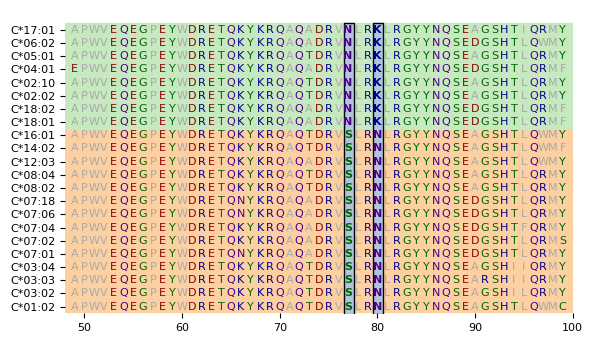

In [20]:
seq_dict_full = {
 'C*04:01': 'SHSMRYFSTSVSWPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPREPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSEDGSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKETLQR',
 'C*07:01': 'SHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQNYKRQAQADRVSLRNLRGYYNQSEDGSHTLQRMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKLEAARAAEQLRAYLEGTCVEWLRRYLENGKETLQR',
 'C*12:03': 'SHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVSLRNLRGYYNQSEAGSHTLQWMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQWRAYLEGTCVEWLRRYLENGKETLQR',
 'C*16:01': 'SHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHTLQWMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAARAAEQQRAYLEGTCVEWLRRYLENGKETLQR',
 'C*03:02': 'SHSMRYFYTAVSRPGRGEPHFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHILQRMYGCDVGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRYLKNGKETLQR',
 'C*03:04': 'SHSMRYFYTAVSRPGRGEPHFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHIIQRMYGCDVGPDGRLLRGYDQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRYLKNGKETLQR',
 'C*06:02': 'SHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSEDGSHTLQWMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQWRAYLEGTCVEWLRRYLENGKETLQR',
 'C*08:04': 'SHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVQFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHTLQRMYGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADKAAQITQRKWEAAREAEQLRAYLEGTCVEWLRRYLENGKKTLQR',
 'C*02:10': 'SHSMRYFYTAVSRPSRGEPHFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVNLRKLRGYYNQSEAGSHTLQRMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQWRAYLEGECVEWLRRYLENGKETLQR',
 'C*18:02': 'SHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSEDGSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKETLQR',
 'C*07:18': 'SHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQNYKRQAQADRVSLRNLRGYYNQSEDGSHTLQRMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKLEAARAAEQLRAYLEGTCVEWLRRYLENGKETLQR',
 'C*08:02': 'SHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVQFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHTLQRMYGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADKAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKKTLQR',
 'C*07:02': 'SHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVSLRNLRGYYNQSEDGSHTLQRMSGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKLEAARAAEQLRAYLEGTCVEWLRRYLENGKETLQR',
 'C*02:02': 'SHSMRYFYTAVSRPSRGEPHFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVNLRKLRGYYNQSEAGSHTLQRMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQWRAYLEGECVEWLRRYLENGKETLQR',
 'C*05:01': 'SHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVQFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVNLRKLRGYYNQSEAGSHTLQRMYGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADKAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKKTLQR',
 'C*17:01': 'SHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSEAGSHTIQRMYGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADTAAQISQRKLEAAREAEQLRAYLEGECVEWLRGYLENGKETLQR',
 'C*03:03': 'SHSMRYFYTAVSRPGRGEPHFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEARSHIIQRMYGCDVGPDGRLLRGYDQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRYLKNGKETLQR',
 'C*14:02': 'SHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHTLQWMFGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKETLQR',
 'C*18:01': 'SHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSEDGSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKETLQR',
 'C*01:02': 'SHSMKYFFTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHTLQWMCGCDLGPDGRLLRGYDQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKETLQR',
 'C*07:04': 'SHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVSLRNLRGYYNQSEDGSHTFQRMYGCDLGPDGRLLRGYDQFAYDGKDYIALNEDLRSWTAADTAAQITQRKLEAARAAEQDRAYLEGTCVEWLRRYLENGKKTLQR',
 'C*07:06': 'SHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQNYKRQAQADRVSLRNLRGYYNQSEDGSHTLQRMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKLEAARAAEQLRAYLEGTCVEWLRRYLENGKETLQR'}
start = 26
arr1 = [4,6,8,32,54,58,62,64,65,66,68,69,72,73,76,79,80,83,94,96,98,99,113,115,122,123,132,142,145,146,149,151,154,155,157,158,159,160,162,163,165,166,170]
arr1 = [x-1 for x in arr1]
arr2 = list(np.arange(1, 9, 1)) + [31, 32, 33] + list(np.arange(53, 100, 1)) + list(np.arange(112, 123)) + list(np.arange(131, 171))

arr1 = arr2
alleles = ['C*01:02', 'C*03:02', 'C*03:03', 'C*03:04', 'C*07:01', 'C*07:02',
             'C*07:04', 'C*07:06', 'C*07:18', 'C*08:02', 'C*08:04', 'C*12:03', 'C*14:02', 'C*16:01',
             'C*18:01', 'C*18:02', 'C*02:02', 'C*02:10', 'C*04:01', 'C*05:01', 'C*06:02', 'C*17:01']

color_dict = {'darkgrey' : ['A', 'F', 'I', 'L', 'M', 'P', 'V', 'W'],
              'darkgreen' : ['C', 'G', 'S', 'T', 'Y'], 'darkred' : ['D', 'E'], 'darkblue' : ['H', 'K', 'R'],
              'indigo' : ['N', 'Q']}

c_colors = plt.get_cmap('tab20c').colors
fig, ax = plt.subplots(figsize=(6., 3.5))
fs=8
resi = np.arange(47, 98, 1)
for ix, s in enumerate(alleles):
    for jx, aa in enumerate(seq_dict_full[s]):
        color = 'black'
        if jx in list(resi):
            fw = 'ultralight'
            for c in color_dict:
                if aa in color_dict[c]:
                    color = c
            if jx in [75, 78]:
                fw = 'heavy'
            ax.text(jx+2, ix, aa, color=color, fontsize=fs, horizontalalignment='center', 
                    verticalalignment='center', fontweight=fw)

ax.fill_between(np.arange(0, 1000, 10), [-1]*100, [13.5]*100, color=c_colors[7])
ax.fill_between(np.arange(0, 1000, 10), [13.5]*100, [21.5]*100, color=c_colors[11])
ax.fill_between([79.55, 80.6], [-1]*2, [21.5]*2, color='lightsteelblue', edgecolor='k')
ax.fill_between([76.55, 77.6], [-1]*2, [21.5]*2, color='lightsteelblue', edgecolor='k')
ax.set_xlim([resi[0] + 1, resi[-1] + 3])
ax.set_ylim([-.5, len(alleles)+.5])
ax.set_yticks(range(0, len(alleles)))
ax.set_yticklabels(alleles)
for key, spine in ax.spines.items():
    spine.set_visible(False)
plt.tight_layout()
plt.savefig('images/Figure4B.svg')
plt.show()
plt.close()

In [21]:
seq_dict_full = {
 'C*04:01': 'SHSMRYFSTSVSWPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPREPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSEDGSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKETLQR',
 'C*07:01': 'SHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQNYKRQAQADRVSLRNLRGYYNQSEDGSHTLQRMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKLEAARAAEQLRAYLEGTCVEWLRRYLENGKETLQR',
 'C*12:03': 'SHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVSLRNLRGYYNQSEAGSHTLQWMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQWRAYLEGTCVEWLRRYLENGKETLQR',
 'C*16:01': 'SHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHTLQWMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAARAAEQQRAYLEGTCVEWLRRYLENGKETLQR',
 'C*03:02': 'SHSMRYFYTAVSRPGRGEPHFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHILQRMYGCDVGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRYLKNGKETLQR',
 'C*03:04': 'SHSMRYFYTAVSRPGRGEPHFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHIIQRMYGCDVGPDGRLLRGYDQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRYLKNGKETLQR',
 'C*06:02': 'SHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSEDGSHTLQWMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQWRAYLEGTCVEWLRRYLENGKETLQR',
 'C*08:04': 'SHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVQFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHTLQRMYGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADKAAQITQRKWEAAREAEQLRAYLEGTCVEWLRRYLENGKKTLQR',
 'C*02:10': 'SHSMRYFYTAVSRPSRGEPHFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVNLRKLRGYYNQSEAGSHTLQRMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQWRAYLEGECVEWLRRYLENGKETLQR',
 'C*18:02': 'SHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSEDGSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKETLQR',
 'C*07:18': 'SHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQNYKRQAQADRVSLRNLRGYYNQSEDGSHTLQRMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKLEAARAAEQLRAYLEGTCVEWLRRYLENGKETLQR',
 'C*08:02': 'SHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVQFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHTLQRMYGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADKAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKKTLQR',
 'C*07:02': 'SHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVSLRNLRGYYNQSEDGSHTLQRMSGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKLEAARAAEQLRAYLEGTCVEWLRRYLENGKETLQR',
 'C*02:02': 'SHSMRYFYTAVSRPSRGEPHFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVNLRKLRGYYNQSEAGSHTLQRMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQWRAYLEGECVEWLRRYLENGKETLQR',
 'C*05:01': 'SHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVQFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVNLRKLRGYYNQSEAGSHTLQRMYGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADKAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKKTLQR',
 'C*17:01': 'SHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSEAGSHTIQRMYGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADTAAQISQRKLEAAREAEQLRAYLEGECVEWLRGYLENGKETLQR',
 'C*03:03': 'SHSMRYFYTAVSRPGRGEPHFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEARSHIIQRMYGCDVGPDGRLLRGYDQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRYLKNGKETLQR',
 'C*14:02': 'SHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHTLQWMFGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKETLQR',
 'C*18:01': 'SHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSEDGSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKETLQR',
 'C*01:02': 'SHSMKYFFTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHTLQWMCGCDLGPDGRLLRGYDQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKETLQR',
 'C*07:04': 'SHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVSLRNLRGYYNQSEDGSHTFQRMYGCDLGPDGRLLRGYDQFAYDGKDYIALNEDLRSWTAADTAAQITQRKLEAARAAEQDRAYLEGTCVEWLRRYLENGKKTLQR',
 'C*07:06': 'SHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQNYKRQAQADRVSLRNLRGYYNQSEDGSHTLQRMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKLEAARAAEQLRAYLEGTCVEWLRRYLENGKETLQR'}

surface = [4,6,8,32,54,58,62,64,65,66,68,69,72,73,76,79,80,83,94,96,98,99,113,115,122,123,132,142,145,146,149,151,154,155,157,158,159,160,162,163,165,166,170]
surface = [x-1 for x in surface]

seq_dict = {}
for s in seq_dict_full:
    seq_dict[s] = [seq_dict_full[s][a] for a in surface]
    
allele_names = list(seq_dict)
sequences = []
for yi in allele_names:
    sequences.append(list(seq_dict[yi]))
    
corpus = pd.DataFrame(data={'id' : allele_names, 'sequence' : sequences})
sgt_ = SGT(kappa=1, lengthsensitive=False) #, mode='multiprocessing')
sgtembedding_df = sgt_.fit_transform(corpus)
sgtembedding_df = sgtembedding_df.set_index('id')

pca = PCA(n_components=2)
pca.fit(sgtembedding_df)
X=pca.transform(sgtembedding_df)
pca_df = pd.DataFrame(data=X, columns=['x1', 'x2'])
kmeans = KMeans(n_clusters=3, max_iter = 300, random_state=0)
kmeans.fit(pca_df)
labels = kmeans.predict(pca_df)
centroids = kmeans.cluster_centers_
kmDF = pd.DataFrame(data={'Allele' : allele_names, 'Label' : labels})
    
km_colors = plt.get_cmap('tab20').colors
km_colors1 = [km_colors[6], km_colors[0], km_colors[8]]
km_colors2 = [km_colors[7], km_colors[1], km_colors[9]]

classif = {'01:02' : 1, '02:02' : 2, '02:10' : 2, '03:02' : 1, '03:03' : 1, '03:04' : 1, '14:02' : 1, '16:01' : 1,
            '04:01' : 2, '05:01' : 2, '08:02' : 1, '08:04' : 1, '17:01' : 2, '18:01' : 2, '18:02' : 2, '06:02' : 2,
            '07:01' : 1, '07:02' : 1, '07:04' : 1, '07:06' : 1, '07:18' : 1, '12:03' : 1}

samples = list(sample_dict)
probabilities = np.arange(0.5, 0.96, 0.01)
sns_samples, cluster, probability, sofa, n, c = [], [], [], [], [], []
for tq, s in zip(tqdm(range(len(samples))), samples):
    tmp = sample_dict[s]
    tmp = tmp[tmp.Allele.str.contains('C')]
    alleles = tmp.Allele.unique()
    if len(alleles) == 1:
        alleles = [alleles[0]]*2
    for a in alleles:
        for p in probabilities:
            n.append(len(tmp[(tmp.Allele == a) & (tmp.Probability >= p)]))
            sofa.append(data[data.SAMPLE_ID == s].HIGHEST_SOFA_10DAY.values[0])
            probability.append(p)
            cluster.append(kmDF[kmDF.Allele == a].Label.values[0])
            sns_samples.append(s)
            c.append(classif[a.replace('C*', '')])
sns_df = pd.DataFrame(data={'Samples' : sns_samples, 'Cluster' : cluster, 'SOFA' : sofa, 'Probability' : probability, 'N' : n, 'C' : c})

c:\Users\mikeo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  0%|          | 0/60 [00:00<?, ?it/s]

C:\Users\mikeo\AppData\Local\Temp\ipykernel_8236\3415570474.py:4: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': (0.9921568627450981, 0.8156862745098039, 0.6352941176470588)}` instead.

  sns.barplot(data=tmp, x='Probability', y='N', color=c_colors[4], ax=ax1, errcolor=c_colors[7])
C:\Users\mikeo\AppData\Local\Temp\ipykernel_8236\3415570474.py:8: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': (0.7803921568627451, 0.9137254901960784, 0.7529411764705882)}` instead.

  sns.barplot(data=tmp, x='Probability', y='N', color=c_colors[8], ax=ax2, errcolor=c_colors[11])


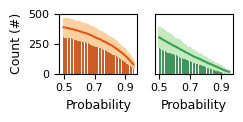

Ttest_indResult(statistic=3.410255421291196, pvalue=0.0010196473231890654)

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2.5, 1.25))

tmp = sns_df[sns_df.C == 1]
sns.barplot(data=tmp, x='Probability', y='N', color=c_colors[4], ax=ax1, errcolor=c_colors[7])
ax1.plot(np.arange(0, len(probabilities), 1), [tmp[tmp.Probability == p].N.mean() for p in probabilities], color=c_colors[4])

tmp = sns_df[sns_df.C == 2]
sns.barplot(data=tmp, x='Probability', y='N', color=c_colors[8], ax=ax2, errcolor=c_colors[11])
ax2.plot(np.arange(0, len(probabilities), 1), [tmp[tmp.Probability == p].N.mean() for p in probabilities], color=c_colors[8])

ax1.set_ylabel('Count (#)')
ax2.set_ylabel('')
ax1.set_ylim([0, 500])
ax2.set_ylim([0, 500])
ax1.set_xticks([0, 20, 40])
ax2.set_xticks([0, 20, 40])
ax1.set_xticklabels([0.5, 0.7, 0.9])
ax2.set_xticklabels([0.5, 0.7, 0.9])
ax2.set_yticks([])
plt.tight_layout()
plt.savefig('images/Figure4C.svg')
plt.show()
plt.close()

ttest_ind(sns_df[sns_df.C == 1].groupby('Samples').mean().N, sns_df[sns_df.C == 2].groupby('Samples').mean().N)

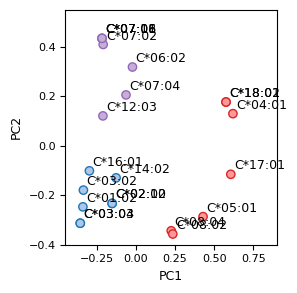

In [23]:
c1 = [km_colors1[x] for x in kmeans.labels_]
c2 = [km_colors2[x] for x in kmeans.labels_]
fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(pca_df.x1, pca_df.x2, color=c2, edgecolor=c1, alpha=1.0, linewidth=1)
for x1, x2, an in zip(pca_df.x1, pca_df.x2, allele_names):
    plt.text(x1+.02, x2+.02, an)
plt.xlim([pca_df.x1.min(), pca_df.x1.max()])
plt.ylim([pca_df.x2.min(), pca_df.x2.max()])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_ylim([-0.4, 0.55])
ax.set_xlim([-0.45, 0.9])
plt.tight_layout()
plt.savefig(join('images', 'Figure5A.svg'))
plt.show()
plt.close()

C:\Users\mikeo\AppData\Local\Temp\ipykernel_8236\1283625799.py:4: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': (1.0, 0.596078431372549, 0.5882352941176471)}` instead.

  sns.barplot(data=tmp, x='Probability', y='N', color=km_colors1[i], ax=ax, errcolor=km_colors2[i])
C:\Users\mikeo\AppData\Local\Temp\ipykernel_8236\1283625799.py:4: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274)}` instead.

  sns.barplot(data=tmp, x='Probability', y='N', color=km_colors1[i], ax=ax, errcolor=km_colors2[i])
C:\Users\mikeo\AppData\Local\Temp\ipykernel_8236\1283625799.py:4: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589)}` instead.

  sns.barplot(data=tmp, x='Probability', y='N', color=km_col

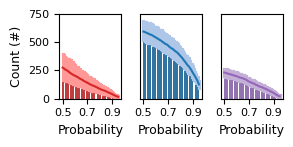

F_onewayResult(statistic=34.62808703687456, pvalue=6.5661576191154765e-12)

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3, 1.5))
for i, ax in zip(range(3), [ax1, ax2, ax3]):
    tmp = sns_df[sns_df.Cluster == i]
    sns.barplot(data=tmp, x='Probability', y='N', color=km_colors1[i], ax=ax, errcolor=km_colors2[i])
    ax.plot(np.arange(0, len(probabilities), 1), [tmp[tmp.Probability == p].N.mean() for p in probabilities], color=km_colors1[i])
    ax.set_ylabel('')
    ax.set_ylim([0, 750])
    ax.set_xticks([0, 20, 40])
    ax.set_xticklabels([0.5, 0.7, 0.9])
ax2.set_yticks([])
ax3.set_yticks([])
ax1.set_ylabel('Count (#)')
plt.tight_layout()
plt.savefig('images/Figure5E.svg')
plt.show()
plt.close()

f_oneway(sns_df[sns_df.Cluster == 2].groupby('Samples').mean().N, sns_df[sns_df.Cluster == 1].groupby('Samples').mean().N, 
         sns_df[sns_df.Cluster == 0].groupby('Samples').mean().N)

In [25]:
samples = list(sample_dict)
sns_samples, cluster, sofa, n, c = [], [], [], [], []
for tq, s in zip(tqdm(range(len(samples))), samples):
    tmp = sample_dict[s]
    tmp = tmp[tmp.Allele.str.contains('C')]
    alleles = tmp.Allele.unique()
    if len(alleles) == 1:
        alleles = [alleles[0]]*2
    for a in alleles:
        n.append(len(tmp[(tmp.Allele == a) & (tmp.Probability >= p)]))
        sofa.append(data[data.SAMPLE_ID == s].HIGHEST_SOFA_10DAY.values[0])
        cluster.append(kmDF[kmDF.Allele == a].Label.values[0])
        sns_samples.append(s)
        c.append(classif[a.replace('C*', '')])
sns_df = pd.DataFrame(data={'Samples' : sns_samples, 'Cluster' : cluster, 'SOFA' : sofa, 'N' : n, 'C' : c})

  0%|          | 0/60 [00:00<?, ?it/s]

C:\Users\mikeo\AppData\Local\Temp\ipykernel_8236\4272071053.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=sns_df, y='SOFA', x='C', cut=0, palette=[c_colors[4], c_colors[8]], ax=ax, inner=None)
C:\Users\mikeo\AppData\Local\Temp\ipykernel_8236\4272071053.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=sns_df, y='SOFA', x='C', palette=[c_colors[7], c_colors[11]], ax=ax)
c:\Users\mikeo\anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 6.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\mikeo\AppData\Local\Temp\ipykernel_8236\4272071053.py:4: UserWarning: F

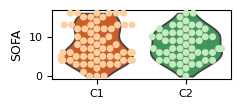

Ttest_indResult(statistic=0.025115668055365383, pvalue=0.9800051270885539)

In [26]:
fig, ax = plt.subplots(figsize=(2.3, 0.9))
sns.violinplot(data=sns_df, y='SOFA', x='C', cut=0, palette=[c_colors[4], c_colors[8]], ax=ax, inner=None)
sns.swarmplot(data=sns_df, y='SOFA', x='C', palette=[c_colors[7], c_colors[11]], ax=ax)
ax.set_xticklabels(['C1', 'C2'])
ax.set_xlabel('')
plt.savefig('images/Figure4D.svg')
plt.show()
plt.close()

b = sns_df[sns_df.C == 1].SOFA.values
c = sns_df[sns_df.C == 2].SOFA.values
ttest_ind(b, c)

C:\Users\mikeo\AppData\Local\Temp\ipykernel_8236\901019442.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=sns_df, y='SOFA', x='Cluster', cut=0, palette=km_colors1, ax=ax, inner=None)
C:\Users\mikeo\AppData\Local\Temp\ipykernel_8236\901019442.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=sns_df, y='SOFA', x='Cluster', palette=km_colors2, ax=ax)
C:\Users\mikeo\AppData\Local\Temp\ipykernel_8236\901019442.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Cluster 1', 'Cluster 2', 'Cluster 3'])


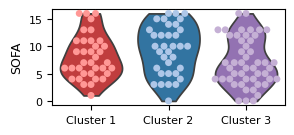

F_onewayResult(statistic=2.978038377558975, pvalue=0.054764366165877335)

In [27]:
fig, ax = plt.subplots(figsize=(3, 1.25))
sns.violinplot(data=sns_df, y='SOFA', x='Cluster', cut=0, palette=km_colors1, ax=ax, inner=None)
sns.swarmplot(data=sns_df, y='SOFA', x='Cluster', palette=km_colors2, ax=ax)
ax.set_xticklabels(['Cluster 1', 'Cluster 2', 'Cluster 3'])
ax.set_xlabel('')
plt.savefig('images/Figure5F.svg')
plt.show()
plt.close()

a = sns_df[sns_df.Cluster == 0].SOFA.values
b = sns_df[sns_df.Cluster == 1].SOFA.values
c = sns_df[sns_df.Cluster == 2].SOFA.values
f_oneway(a, b, c)

C:\Users\mikeo\AppData\Local\Temp\ipykernel_8236\4012876656.py:31: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


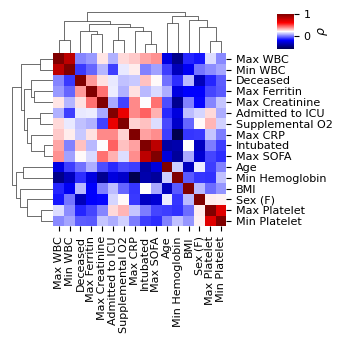

Min Hemoglobin    -0.385575
Sex (F)           -0.266274
Age               -0.245226
Min Platelet      -0.101475
Max Platelet      -0.060908
Min WBC            0.076175
BMI                0.087224
Max Ferritin       0.161302
Supplemental O2    0.171094
Deceased           0.229788
Admitted to ICU    0.336078
Max WBC            0.385714
Max CRP            0.394515
Max Creatinine     0.434025
Intubated          0.812780
Max SOFA           1.000000
Name: Max SOFA, dtype: float64

In [28]:
DF = pd.read_excel('../../20210919_affinity_predictions2/COVIDdata4.22.2022.xlsx')
DF['Age at admission/diagnosis'] = pd.to_numeric(DF['Age at admission/diagnosis'].replace('.', np.nan))
for c in DF.columns:
    DF[c] = DF[c].replace('Not Applicable', np.nan)
    DF[c] = DF[c].replace('Not applicable', np.nan)
DF = DF[DF.SAMPLE_ID.isin(data.SAMPLE_ID)]

CLIN = pd.DataFrame(data={
'AGE' : pd.to_numeric(DF['Age at admission/diagnosis']),
'BMI' : pd.to_numeric(DF['BMI']),
'SEX_F' : pd.get_dummies(DF.SEX).Female,
'ICU' : pd.get_dummies(DF.YN_ICU).Y,
'INTUBATED' : pd.get_dummies(DF.YN_Intub).Y,
'SUPPLEMENT_O2' : pd.get_dummies(DF.YN_SUPPLEMENT_O2).Y,
'DECEASED' : pd.get_dummies(DF.ALIVE_AT_DISCHARGE).N,
'MAX_CRP' : DF[['HIGHEST_CRP_3DAY', 'HIGHEST_CRP_7TO10DAY']].max(axis=1),
'MAX_FERRITIN' : DF[['HIGHEST_FERRITIN_3DAY', 'HIGHEST_FERRITIN_7TO10DAY']].max(axis=1),
'MAX_CREATININE' : DF[['HIGHEST_CREATININE_3DAY', 'HIGHEST_CREATININE_7TO10DAY']].max(axis=1),
'MAX_WBC' : DF[['HIGHEST_WBC_3DAY', 'HIGHEST_WBC_7TO10DAY']].max(axis=1),
'MIN_WBC' : DF[['LOWEST_WBC_3DAY', 'LOWEST_WBC_7TO10DAY']].min(axis=1),
'MIN_HEMOGLOBIN' : DF[['LOWEST_HB_3DAY', 'LOWEST_HB_7TO10DAY']].min(axis=1),
'MAX_PLATELET' : DF[['HIGHEST_PLATELET_3DAY', 'HIGHEST_PLATELET_7TO10DAY']].max(axis=1),
'MIN_PLATELET': DF[['LOWEST_PLATELET_3DAY', 'LOWEST_PLATELET_7TO10DAY']].min(axis=1),
'MAX_SOFA' : DF[['HIGHEST_SOFA_3DAY', 'HIGHEST_SOFA_7TO10DAY']].max(axis=1)
})

CLIN.columns = ['Age', 'BMI', 'Sex (F)', 'Admitted to ICU', 'Intubated', 'Supplemental O2', 'Deceased', 'Max CRP', 'Max Ferritin', 'Max Creatinine', 'Max WBC', 'Min WBC', 'Min Hemoglobin', 'Max Platelet', 'Min Platelet', 'Max SOFA']

sns.clustermap(CLIN.corr(), cmap='seismic', figsize=(3.5, 3.5), cbar_kws={'label' : r'$\rho$'}, cbar_pos=[0.80, 0.85, .05, .1])
#plt.text(-7.4, 1, 'A')
plt.tight_layout()
plt.savefig('./images/FigureS1.jpg', dpi=300)
plt.show()
plt.close()

CLIN.corr()['Max SOFA'].sort_values()

C:\Users\mikeo\AppData\Local\Temp\ipykernel_8236\1987624443.py:62: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


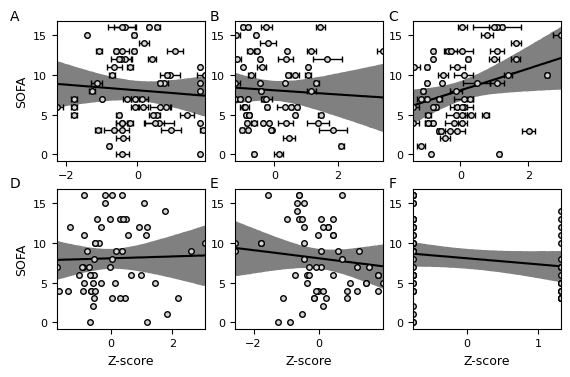

In [29]:
A = pd.read_csv('./output/conditional_effects_A.csv')
B = pd.read_csv('./output/conditional_effects_B.csv')
C = pd.read_csv('./output/conditional_effects_C.csv')
sex = pd.read_csv('./output/conditional_effects_sex.csv')
age = pd.read_csv('./output/conditional_effects_age.csv')
bmi = pd.read_csv('./output/conditional_effects_bmi.csv')
scatter = pd.read_csv('./output/conditional_effects_SOFA.csv')

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(6.5, 4))

ms = 4

ax1.plot(A.effect1__, A.estimate__, color='k')
ax1.fill_between(A.effect1__, A.lower__, A.upper__, alpha=1, color='grey')
ax1.errorbar(scatter.Am, scatter.y, xerr=scatter.As, fmt='o', color='lightgrey', ms=ms, linewidth=1, capsize=2, ecolor='k', alpha=1, markeredgecolor='k')
ax1.set_xlim([min(A.effect1__), max(A.effect1__)])
#ax1.set_title('HLA-A')

ax2.plot(B.effect1__, B.estimate__, color='k')
ax2.fill_between(B.effect1__, B.lower__, B.upper__, alpha=1, color='grey')
ax2.errorbar(scatter.Bm, scatter.y, xerr=scatter.Bs, fmt='o', color='lightgrey', ms=ms, linewidth=1, capsize=2, ecolor='k', alpha=1, markeredgecolor='k')
ax2.set_xlim([min(B.effect1__), max(B.effect1__)])
#ax2.set_title('HLA-B')

ax3.plot(C.effect1__, C.estimate__, color='k')
ax3.fill_between(C.effect1__, C.lower__, C.upper__, alpha=1, color='grey')
ax3.errorbar(scatter.Cm, scatter.y, xerr=scatter.Cs, fmt='o', color='lightgrey', ms=ms, linewidth=1, capsize=2, ecolor='k', alpha=1, markeredgecolor='k')
ax3.set_xlim([min(C.effect1__), max(C.effect1__)])
#ax3.set_title('HLA-C')

ax4.plot(bmi.effect1__, bmi.estimate__, color='k')
ax4.fill_between(bmi.effect1__, bmi.lower__, bmi.upper__, alpha=1, color='grey')
ax4.errorbar(scatter.BMI, scatter.y, fmt='o', color='lightgrey', ms=ms, linewidth=1, capsize=2, ecolor='k', alpha=1, markeredgecolor='k')
ax4.set_xlim([min(bmi.effect1__), max(bmi.effect1__)])
#ax4.set_title('Age')

ax5.plot(age.effect1__, age.estimate__, color='k')
ax5.fill_between(age.effect1__, age.lower__, age.upper__, alpha=1, color='grey')
ax5.errorbar(scatter.Age, scatter.y, fmt='o', color='lightgrey', ms=ms, linewidth=1, capsize=2, ecolor='k', alpha=1, markeredgecolor='k')
ax5.set_xlim([min(age.effect1__), max(age.effect1__)])
#ax5.set_title('BMI')

ax6.plot(sex.effect1__, sex.estimate__, color='k')
ax6.fill_between(sex.effect1__, sex.lower__, sex.upper__, alpha=1, color='grey')
ax6.errorbar(scatter.Sex, scatter.y, fmt='o', color='lightgrey', ms=ms, linewidth=1, capsize=2, ecolor='k', alpha=1, markeredgecolor='k')
ax6.set_xlim([min(sex.effect1__), max(sex.effect1__)])
#ax6.set_title('Sex (F)')

ax1.set_ylabel('SOFA')
ax4.set_ylabel('SOFA')
ax4.set_xlabel('Z-score')
ax5.set_xlabel('Z-score')
ax6.set_xlabel('Z-score')

plt.text(-6.4, 38, 'A', fontsize=10)
plt.text(-3.6, 38, 'B', fontsize=10)
plt.text(-1.1, 38, 'C', fontsize=10)
plt.text(-6.4, 17, 'D', fontsize=10)
plt.text(-3.6, 17, 'E', fontsize=10)
plt.text(-1.1, 17, 'F', fontsize=10)

plt.tight_layout()
plt.savefig('images/FigureS2.jpg', dpi=300)
plt.show()
plt.close()

In [30]:
if 'correlation_dict.pkl' in listdir('./output'):
    with open('./output/correlation_dict.pkl', 'rb') as f:
        correlation_dict = pickle.load(f)
else:
    correlation_dict = nestedDict()
    for tq, row in zip(tqdm(range(len(data))), data.iterrows()):
        sample = row[1].SAMPLE_ID
        sofa = row[1].HIGHEST_SOFA_10DAY
        correlation_dict[sample]['SOFA'] = sofa
        data = sample_dict[sample]
        for gene in ['A', 'B', 'C']:
            for protein in data.Protein.unique():
                for cutoff in np.arange(0.5, 0.95, 0.01):
                    n = len(data[(data.Allele.str.contains(gene)) & (data.Protein == protein) & (data.Probability >= cutoff)])
                    correlation_dict[sample][gene][protein][cutoff] = n
    with open('./output/correlation_dict.pkl', 'wb') as f:
        pickle.dump(correlation_dict, f)

  0%|          | 0/60 [00:00<?, ?it/s]

In [31]:
C = []
samples = list(correlation_dict)
proteins = ['NSP1', 'NSP2', 'NSP3', 'NSP4', 'NSP5', 'NSP6', 'NSP7', 'NSP8', 'NSP9', 'NSP10', 'NSP11', 'NSP12', 'NSP13', 'NSP14', 'NSP15', 'NSP16', 'Spike',
              'NS3', 'E', 'M', 'NS6', 'NS7a', 'NS7b', 'NS8', 'NS9b', 'NS9c', 'N']
for gene in ['A', 'B', 'C']:
    g = []
    for cutoff in np.arange(0.5, 0.96, 0.01):
        c = []
        for protein in proteins:
            tmp = [correlation_dict[s][gene][protein][cutoff] for s in list(samples)]
            x = []
            for t in tmp:
                if isinstance(t, int) == False:
                    x.append(0)
                else:
                    x.append(t)
            y = [correlation_dict[s]['SOFA'] for s in list(samples)]
            c.append(pearsonr(x, y)[0])
        g.append(c)
    C.append(g)

c:\Users\mikeo\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [32]:
rho, p = [], []
for tq, i in zip(tqdm(range(10000)), range(10000)):
    m = np.random.randint(0, 100, 60)
    n = np.random.randint(0, 100, 60)
    pear = pearsonr(m, n)
    rho.append(pear[0])
    p.append(pear[1])

  0%|          | 0/10000 [00:00<?, ?it/s]

In [33]:
sofa, C1, C2, cl0, cl1, cl2 = [], [], [], [], [], [] 
for s in sns_df.Samples.unique():
    tmp = sns_df[sns_df.Samples == s]
    c = list(tmp.C.values)
    cl = list(tmp.Cluster.values)
    sofa.append(tmp.SOFA.values[0])
    C1.append(c.count(1))
    C2.append(c.count(2))
    cl0.append(cl.count(0))
    cl1.append(cl.count(1))
    cl2.append(cl.count(2))
geno_df = pd.DataFrame(data={'SOFA' : sofa, 'C1' : C1, 'C2' : C2, 'CL1' : cl0, 'CL2' : cl1, 'CL3' : cl2})

C:\Users\mikeo\AppData\Local\Temp\ipykernel_8236\1181689282.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=geno_df, x='C1', y='SOFA', palette=[tabc[5], tabc[6], tabc[7]], edgecolor='k', linewidth=1, ax=ax1)
C:\Users\mikeo\AppData\Local\Temp\ipykernel_8236\1181689282.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=geno_df, x='C1', y='SOFA', palette=[tabc[4], tabc[5], tabc[6]], ax=ax1, cut=0)
C:\Users\mikeo\AppData\Local\Temp\ipykernel_8236\1181689282.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=geno_df, x

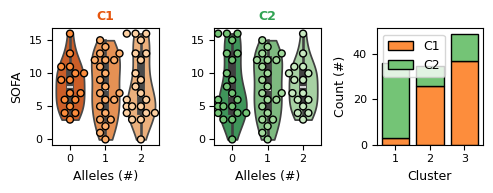

F_onewayResult(statistic=0.03604837293323632, pvalue=0.9646156046475096)

In [34]:
tabc = plt.get_cmap('tab20c').colors
tabb = plt.get_cmap('tab20b').colors

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(5, 2))

sns.swarmplot(data=geno_df, x='C1', y='SOFA', palette=[tabc[5], tabc[6], tabc[7]], edgecolor='k', linewidth=1, ax=ax1)
sns.violinplot(data=geno_df, x='C1', y='SOFA', palette=[tabc[4], tabc[5], tabc[6]], ax=ax1, cut=0)

sns.swarmplot(data=geno_df, x='C2', y='SOFA', palette=[tabc[9], tabc[10], tabc[11]], edgecolor='k', linewidth=1, ax=ax2)
sns.violinplot(data=geno_df, x='C2', y='SOFA', palette=[tabc[8], tabc[9], tabc[10]], ax=ax2, cut=0)

x = [0, 1, 2]
y1 = []
for i in range(3):
    y1.append(len(sns_df[(sns_df.Cluster == i) & (sns_df.C == 1)]))
y2 = []
for i in range(3):
    y2.append(len(sns_df[(sns_df.Cluster == i) & (sns_df.C == 2)]))
ax3.bar(x, y1, color=tabc[5], edgecolor='k', label='C1')
ax3.bar(x, y2, bottom=y1, color=tabc[9], edgecolor='k', label='C2')
ax3.legend()
ax3.set_ylabel('Count (#)')
ax3.set_xticks([0, 1, 2])
ax3.set_xticklabels([1, 2, 3])
ax3.set_xlabel('Cluster')
ax1.set_title('C1', color=tabc[4], fontweight='heavy')
ax2.set_title('C2', color=tabc[8], fontweight='heavy')
ax2.set_ylabel('')
ax1.set_xlabel('Alleles (#)')
ax2.set_xlabel('Alleles (#)')
plt.tight_layout()
plt.savefig('images/FigureS3ABC.svg')
plt.show()
plt.close()

a = geno_df[geno_df.C1 == 0].SOFA.values
b = geno_df[geno_df.C1 == 1].SOFA.values
c = geno_df[geno_df.C1 == 2].SOFA.values
f_oneway(a, b, c)

C:\Users\mikeo\AppData\Local\Temp\ipykernel_8236\3824047955.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=geno_df, x='CL1', y='SOFA', palette=['indianred', 'lightcoral', 'pink'], edgecolor='k', linewidth=1, ax=ax1)
C:\Users\mikeo\AppData\Local\Temp\ipykernel_8236\3824047955.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=geno_df, x='CL1', y='SOFA', palette=['firebrick', 'indianred', 'lightcoral'], ax=ax1, cut=0)
C:\Users\mikeo\AppData\Local\Temp\ipykernel_8236\3824047955.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.sw

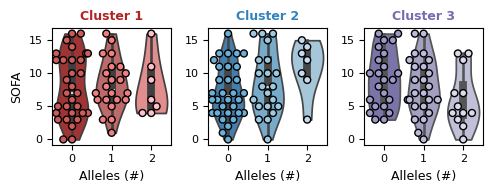

F_onewayResult(statistic=0.03888676331176593, pvalue=0.9618851155633887)
F_onewayResult(statistic=2.171436623060722, pvalue=0.12335482315211532)
F_onewayResult(statistic=1.9270235627631598, pvalue=0.15494714986736596)


In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(5, 2))

sns.swarmplot(data=geno_df, x='CL1', y='SOFA', palette=['indianred', 'lightcoral', 'pink'], edgecolor='k', linewidth=1, ax=ax1)
sns.violinplot(data=geno_df, x='CL1', y='SOFA', palette=['firebrick', 'indianred', 'lightcoral'], ax=ax1, cut=0)

sns.swarmplot(data=geno_df, x='CL2', y='SOFA', palette=[tabc[1], tabc[2], tabc[3]], edgecolor='k', linewidth=1, ax=ax2)
sns.violinplot(data=geno_df, x='CL2', y='SOFA', palette=[tabc[0], tabc[1], tabc[2]], ax=ax2, cut=0)

sns.swarmplot(data=geno_df, x='CL3', y='SOFA', palette=[tabc[13], tabc[14], tabc[15]], edgecolor='k', linewidth=1, ax=ax3)
sns.violinplot(data=geno_df, x='CL3', y='SOFA', palette=[tabc[12], tabc[13], tabc[14]], ax=ax3, cut=0)

ax1.set_title('Cluster 1', color='firebrick', fontweight='heavy')
ax2.set_title('Cluster 2', color=tabc[0], fontweight='heavy')
ax3.set_title('Cluster 3', color=tabc[12], fontweight='heavy')
ax1.set_xlabel('Alleles (#)')
ax2.set_xlabel('Alleles (#)')
ax3.set_xlabel('Alleles (#)')
ax2.set_ylabel('')
ax3.set_ylabel('')
plt.tight_layout()
plt.savefig('images/Figure6DF.svg')
plt.show()
plt.close()

a = geno_df[geno_df.CL1 == 0].SOFA.values
b = geno_df[geno_df.CL1 == 1].SOFA.values
c = geno_df[geno_df.CL1 == 2].SOFA.values
print(f_oneway(a, b, c))

a = geno_df[geno_df.CL2 == 0].SOFA.values
b = geno_df[geno_df.CL2 == 1].SOFA.values
c = geno_df[geno_df.CL2 == 2].SOFA.values
print(f_oneway(a, b, c))

a = geno_df[geno_df.CL3 == 0].SOFA.values
b = geno_df[geno_df.CL3 == 1].SOFA.values
c = geno_df[geno_df.CL3 == 2].SOFA.values
print(f_oneway(a, b, c))